# Data Preparation
This notebook details the data preparation steps for Comper.

## 1. Grab the dataset
1. Go to [https://salu133445.github.io/musegan/dataset](https://salu133445.github.io/musegan/dataset)
2. Download the `lpd-5-cleansed.tgz` dataset.
3. Extract it into a folder `lpd-5-cleansed`.
4. You should see three layers of subfolders labelled 'A'-'J', and then leaf folders named something like `TRJJFLV128F92FC46E/`, each containing a file which looks something like `c28d6d22cf7298890c5cc5f21ac2244d.npz` (this is a numpy zip file, more information [here](https://salu133445.github.io/pypianoroll/save_load.html))

## 2. Flatten all files into one folder

1. `cd` to the root of your dataset.
2. Check that there are 24474 .npz files using 
```bash
find . -mindepth 2 -type f | wc -l
```
3. Move all files to the current directory for easier access later: 
```bash
find . -mindepth 2 -type f -print -exec mv --backup=numbered {} . \;
``` 
([What?](https://askubuntu.com/questions/146634/shell-script-to-move-all-files-from-subfolders-to-parent-folder))
4. Rename all "~#~" extensions to "~#.npz" so that numpy doesn't reject the file later on.
```bash
rename 's/\~$/\.npz/' *~
```
4. Remove the empty folders `rm -r */` (Don't forget the slash!)
5. Confirm that you have the correct number of files using `ls | wc -l`.


## 3. Grab a random subset of files to play with
We'll use 100 files to start. 

In [1]:
import os, shutil
import random
import sys
import numpy as np
import pypianoroll
from matplotlib import pyplot as plt
import cPickle as pickle
import pianoroll_utils

LPD5_DIR = "/media/junshern/s_drive/FYP/MIDI/lpd_5_cleansed_copy"
DATA_DIR = "./pianorolls"
NUM_FILES = 50
PICKLE_FILE = './pickle_jar/units_50_songs.pkl'

In [2]:

# Create a new directory for our pianorolls
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)
    # Grab a random subset of files from our LPD5 dataset to play with
    files_subset = random.sample(os.listdir(LPD5_DIR), NUM_FILES) # Sampling without replacement
    for filename in files_subset:
        src = os.path.join(LPD5_DIR, filename)
        dest = os.path.join(DATA_DIR, filename)
        shutil.copyfile(src, dest)
    print "Copied", NUM_FILES, "files to", DATA_DIR, "."
else:
    print "Directory already exists."

# Print the first 10 files of our chosen subset
print(os.listdir(DATA_DIR)[:10])

Copied 50 files to ./pianorolls .
['82d301e5a595ea741183f694bf5333c5.npz', 'f3e8ec774bf6a416355aa7554db571d9.npz', 'e50e5161e6ebf992fc6cbc03407a59ba.npz', 'd78ea7a9cc48779c717d84f46afa1263.npz.~1.npz', '143ee97082008e4f8781979fe2e42d76.npz.~1.npz', '028f242a4573a4fa2373480618591140.npz', 'fb1c1d20de77b9619b6ec2bebd9a49ee.npz.~1.npz', '7ae9810f15c6da1b35bf98428fa66b3c.npz', '57b45416770340f660095e4388e43d8a.npz', 'a552450902e407fd0d47149582562860.npz']


## 4. Inspect the data

From the MuseGAN page:

> In LPD-5, the tracks of each multi-track piano-rolls are merged into five common categories: bass, drums, piano, guitar and strings according to the program numbers provided in the MIDI files. Note that instruments out of the list are considered as part of the strings

We use [pypianoroll](https://github.com/salu133445/pypianoroll), created by the authors of MuseGAN to manipulate the data. The pypianoroll library gives us a ton of helpful methods which makes it easy to find out more about each file. (pypianoroll [docs](https://salu133445.github.io/pypianoroll/index.html))

In [3]:

def printInfo(track):
    print "\n#####################"
    print "Name: ", track.name
    print "isDrum: ", track.is_drum
    print "Program: ", track.program
    if len(track.pianoroll):
        print "Active length: ", track.get_active_length()
        print "Active pitch range: ", track.get_active_pitch_range()
    else:
        print "Empty pianoroll."
    print ""

# Pick a file to look at
filename = random.choice(os.listdir(DATA_DIR))
print(filename)
# Load pianoroll file as a multitrack object
multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
print "Tempo: ", multi.tempo
print "Beat resolution: ", multi.beat_resolution
# Show some info about the pianoroll
for track in multi.tracks:
    printInfo(track)


d78ea7a9cc48779c717d84f46afa1263.npz.~1.npz
Tempo:  [122.00081334 122.00081334 122.00081334 ... 122.00081334 122.00081334
 122.00081334]
Beat resolution:  24

#####################
Name:  Guitar
isDrum:  False
Program:  24
Active length:  14590
Active pitch range:  (24, 67)


#####################
Name:  Piano
isDrum:  False
Program:  0
Active length:  7486
Active pitch range:  (46, 65)


#####################
Name:  Bass
isDrum:  False
Program:  32
Empty pianoroll.


#####################
Name:  Drums
isDrum:  True
Program:  0
Active length:  14586
Active pitch range:  (35, 57)


#####################
Name:  Strings
isDrum:  False
Program:  48
Active length:  14592
Active pitch range:  (43, 79)



## 5. Extract pianorolls from the Piano track of all files

In [4]:
pianorolls = [] # List to hold all our piano rolls
for filename in os.listdir(DATA_DIR):
    # Load pianoroll file as a multitrack object
    multi = pypianoroll.Multitrack(os.path.join(DATA_DIR, filename))
    for track in multi.tracks:
        # Non-empty piano pianoroll
        if track.name == "Piano" and track.pianoroll.shape[0] > 0:
            pianorolls.append(track.pianoroll)
print "Complete. Number of pianorolls collected: ", len(pianorolls)

Complete. Number of pianorolls collected:  33



## 6. Unit sampling

Our model deals with predicting musical _units_ of a pianoroll, which can be for example 4 beats of a pianoroll depending on the chosen `BEATS_PER_UNIT`. The datasets we prepare must then correspond to input/output pairs of musical units.

### Model objectives

Given an input unit at time $t$, predict an output unit which may be either (depending on a user-selected prediction mode)
1. The following unit at time $t+1$
2. An accompaniment unit at time $t$
3. An accompaniment unit at time $t+1$

In the 1st case, the output is simply the _next-step prediction_, used commonly by most composition algorithms. 

In the 2nd case, the output is an _accompanying pianoroll of the current unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment for that input.

In the 3rd (expectedly most difficult) case, the output is an _accompanying pianoroll of the next unit_, either the left-accompaniment or right-accompaniment. For example, given an input pianoroll which is a right-accompaniment, the model will be expected to predict the left-accompaniment at the next time step.

### Unit creation

To help the model learn accompaniments, we split each pianoroll from our dataset into two complementary pianorolls which serve as accompaniments for each other. This is done in a naive way, using the `PARTITION_NOTE` as the splitting point to divide the pianoroll along the pitch axis into left- and right- accompaniments (as in left and right hand of a piano player). This approach was inspired by \[Bretan et al\]. 

Each of these pianoroll segments (of fixed tick-length and only containing notes for either left- or right- accompaniments) will be used as a single unit, and is represented by a matrix of shape `[TICKS_PER_UNIT, NUM_PITCHES=128]`. 

The input and output matrices of our model will have the same shape.

### Data structure

Since all units have the same shape, this makes it easy to store the data as a 3-dimensional matrix of depth $M$, where $M$ is the number of units (data points).

We will create 4 matrices comprising of: the input units, the next step units, the accompaniment units, and the next step accompaniment units. 

```
input_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
input_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
comp_units.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
comp_units_next.shape = [M, TICKS_PER_UNIT, NUM_PITCHES=128]
```

The unit dimension is ordered are ordered such that the $i$-th input has an output at the $i$-th element of each output matrix. (eg. given `input_units[i,:,:]`, the model should predict `input_units_next[i,:,:]`, `comp_units[i,:,:]`, or `comp_units_next[i,:,:]`)

In [5]:
# Dataset definitions
NUM_PITCHES = 128
PARTITION_NOTE = 60 # Break into left- and right-accompaniments at middle C
BEAT_RESOLUTION = 24 # This is set by the encoding of the lpd-5 dataset, corresponds to number of ticks per beat
BEATS_PER_UNIT = 4
TICKS_PER_UNIT = BEATS_PER_UNIT * BEAT_RESOLUTION
MEAN_THRESHOLD = 0.5 # Filter out units with mean values less than 0.5
NUM_TRANSPOSITIONS = 3 # Number of transpositions to perform (maximum 12)


In [6]:
def chop_to_unit_multiple(pianoroll, ticks_per_unit):
    """
    Given an input pianoroll matrix of shape [NUM_TICKS, NUM_PITCHES],
    truncate the matrix so that it can be evenly divided into M units.
    
    Returns [M, pianoroll_truncated]
    where M is the largest integer such that M*ticks_per_unit <= NUM_TICKS
    and pianoroll_truncated is of shape [M*ticks_per_unit, NUM_PITCHES]
    """
    
    num_ticks = pianoroll.shape[0]
    num_pitches = pianoroll.shape[1]
    
    # Get M
    M = int(num_ticks / ticks_per_unit) # Floor
    # Truncate
    pianoroll_truncated = pianoroll[:M*ticks_per_unit, :]
    
    # Debug assertions
    assert(M*ticks_per_unit <= num_ticks)
    assert(pianoroll_truncated.shape == (M*ticks_per_unit, num_pitches))
    
    return [M, pianoroll_truncated]


def shuffle_left_right(left_units, left_units_next, right_units, right_units_next):
    """
    Given 4 matrices left, left_next, right, and right_next
    return 4 matrices which have left and right randomly exchanged
    while maintaining index order, eg:
    
    [a1,a2,a3,a4]      [a1,b2,b3,a4]
    [a2,a3,a4,a5]  ->  [a2,b3,b4,a5]
    [b1,b2,b3,b4]      [b1,a2,a3,b4]
    [b2,b3,b4,b5]      [b2,a3,a4,b5]
    """
    
    bool_array = np.random.randint(0, 2, left_units.shape[0], dtype=bool) # Random True/False
    
    # Initialize as copies of one side of the accompaniment
    input_units = left_units.copy()
    input_units_next = left_units_next.copy()
    comp_units = right_units.copy()
    comp_units_next = right_units_next.copy()

    # Replace half of array with elements from the other side
    input_units[bool_array, ...] = right_units[bool_array, ...]
    input_units_next[bool_array, ...] = right_units_next[bool_array, ...]
    comp_units[bool_array, ...] = left_units[bool_array, ...]
    comp_units_next[bool_array, ...] = left_units_next[bool_array, ...]
    
    return [input_units, input_units_next, comp_units, comp_units_next]


def create_units(pianoroll, filter_threshold=0):
    """
    Given an input pianoroll matrix of shape [NUM_TICKS, NUM_PITCHES], 
    return input_units, input_units_next, comp_units, comp_units_next_shape
    all of the same shape [M, TICKS PER UNIT, NUM_PITCHES]
    """
    assert(pianoroll.shape[1] == NUM_PITCHES)
    
    # Truncate pianoroll so it can be evenly divided into units
    # Pianoroll is divided into M+1, not M 
    # since we can only get M next-units for M+1 input units
    [M_plus_one, pianoroll] = chop_to_unit_multiple(pianoroll, TICKS_PER_UNIT)
    M = M_plus_one - 1
    
    # Prepare outputs
    input_units = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    input_units_next = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    comp_units = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    comp_units_next = np.zeros([M, TICKS_PER_UNIT, NUM_PITCHES])
    
    # Split pianoroll into left- and right- accompaniments
    left_comp = pianoroll.copy()
    left_comp[:, PARTITION_NOTE:] = 0
    right_comp = pianoroll.copy()
    right_comp[:, :PARTITION_NOTE] = 0
    
    # Get the units by reshaping left_comp and right_comp
    all_left_units = left_comp.reshape(M_plus_one, TICKS_PER_UNIT, NUM_PITCHES)
    all_right_units = right_comp.reshape(M_plus_one, TICKS_PER_UNIT, NUM_PITCHES)
    left_units = all_left_units[:-1,:,:] # All but the last unit
    left_units_next = all_left_units[1:,:,:] # Skip the first unit
    right_units = all_right_units[:-1,:,:] # All but the last unit
    right_units_next = all_right_units[1:,:,:] # Skip the first unit
    
    # Randomly choose between left/right for input/comp units, 
    # so the model learns both sides of the accompaniment
    [input_units, input_units_next, comp_units, comp_units_next] = \
        shuffle_left_right(left_units, left_units_next, right_units, right_units_next)
    
    # Filter out near-empty units
    input_units_means = np.mean(input_units, axis=(1,2)).squeeze()
    filter_array = input_units_means > filter_threshold
    input_units = input_units[filter_array, ...]
    input_units_next = input_units_next[filter_array, ...]
    comp_units = comp_units[filter_array, ...]
    comp_units_next = comp_units_next[filter_array, ...]
    
    # Filter out duplicate units
    if input_units.shape[0] > 0: # In case previous step filtered everything out
        _, unique_inds = np.unique(input_units, axis=0, return_index=True)
        input_units = input_units[unique_inds, ...]
        input_units_next = input_units_next[unique_inds, ...]
        comp_units = comp_units[unique_inds, ...]
        comp_units_next = comp_units_next[unique_inds, ...]
    
    M = input_units.shape[0] # Recount M after filtering
    
    # Debug assertions
    assert(input_units.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(input_units_next.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(comp_units.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    assert(comp_units_next.shape == (M, TICKS_PER_UNIT, NUM_PITCHES))
    
    return [input_units, input_units_next, comp_units, comp_units_next]


## 7. Filtering out near-empty units

When we plot a full pianoroll, it becomes clear that many of the units we extract from the roll will be close to empty. Since these units don't hold any useful information, we discard them by filtering out any units with a mean value smaller than `MEAN_THRESHOLD`. It is expected that the mean of a non-empty unit will have a value comparable to 1, since non-normalized pianorolls have values between $[0,127]$, and there are 127 pitch classes. Hence a full-velocity single note at one tick instance will have a mean value of 1.

For example, a `MEAN_THRESHOLD` of 0.5 means that we wish to keep only units that on average, have at least a half-velocity note at each tick.

Overall unit means:  1.8961181640624996
Before filtering:  (38, 96, 128)
Filter threshold:  0.5
After filtering:  (38, 96, 128)


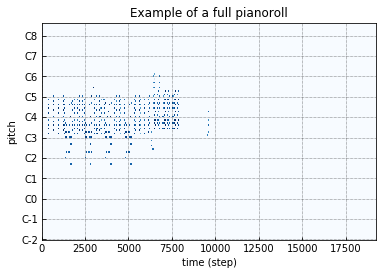

In [7]:
# Inspect pianoroll
pianoroll = random.choice(pianorolls)
fig, ax = plt.subplots()
ax.set_title("Example of a full pianoroll")
pypianoroll.plot_pianoroll(ax, pianoroll)

# Without filtering
[input_units, input_units_next, comp_units, comp_units_next] = create_units(pianoroll)
input_units_means = np.mean(input_units, axis=(1,2)).squeeze()
print "Overall unit means: ", np.mean(input_units_means)
print "Before filtering: ", input_units.shape

# Filter out empty units
print "Filter threshold: ", MEAN_THRESHOLD
[input_units, input_units_next, comp_units, comp_units_next] = create_units(pianoroll, MEAN_THRESHOLD)
print "After filtering: ", input_units.shape

## 8. Data augmentation - transpose to all keys
Melody and harmony are portable - in the sense that so long as relative intervals are maintained, the starting pitch, or the key of the music, can be transposed freely. In that sense, using for instance a 127-pitch system, each song in our dataset can actually be transposed into 127 equally valid songs. However, in most cases pianists tend to stick around the center of the keyboard, so we are only interested in teaching our model the concept of key-invariance, for which we need to represent each song in 12 different keys (the number of semitones in an octave).

Transposition is achieved quite simply in a pianoroll representation. For a key shift of 1 semitone, we simply shift all data in the pianoroll matrix up by one row (along the pitch axis). We perform data augmentation by shifting each pianoroll between -5 and +6 semitones, to create 12\* copies of each song in different keys (including the original key). 

\* <i>An option NUM\_TRANSPOSITIONS is given to allow for fewer transpositions to be made, to save space/computation time.</i>


In [9]:

# This will take a while...
pianorolls_original = pianorolls # Store this somewhere else
print "Transposing", len(pianorolls_original), "pianorolls. This might take a while..."
pianorolls = []
for pianoroll in pianorolls_original:
    print ".",
    # Transpose each pianoroll NUM_TRANSPOSITIONS times
    for i in np.random.choice(range(-5,7), NUM_TRANSPOSITIONS, replace=False):
        transposed_pianoroll = pianoroll_utils.get_transposed_pianoroll(pianoroll, i)
        pianorolls.append(transposed_pianoroll)
print "Done."
print "New pianorolls has", len(pianorolls), "items."


Transposing 33 pianorolls. This might take a while...
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done.
New pianorolls has 99 items.


## 9. Take units from all pianorolls

In [10]:
units = {} # Dictionary to store all data
units["input"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)
units["input_next"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)
units["comp"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)
units["comp_next"] = np.array([]).reshape(0, TICKS_PER_UNIT, NUM_PITCHES)

for pianoroll in pianorolls:
    print ".",
    # Get the units for this pianoroll
    [input_units, input_units_next, comp_units, comp_units_next] = create_units(pianoroll, MEAN_THRESHOLD)
    # Append it to the full dataset
    units["input"] = np.concatenate([units["input"], input_units], axis=0)
    units["input_next"] = np.concatenate([units["input_next"], input_units_next], axis=0)
    units["comp"] = np.concatenate([units["comp"], comp_units], axis=0)
    units["comp_next"] = np.concatenate([units["comp_next"], comp_units_next], axis=0)
print("Done extracting units.")

# Print info
print "Collected", units["input"].shape[0], "units from", len(pianorolls), "pianorolls."
print "input_units.shape: ", units["input"].shape
print "input_units_next.shape: ", units["input_next"].shape
print "comp_units.shape: ", units["comp"].shape
print "comp_units_next.shape: ", units["comp_next"].shape

# Save data in a pickle file
with open(PICKLE_FILE, 'wb') as outfile:
    pickle.dump(units, outfile, protocol=pickle.HIGHEST_PROTOCOL)
print "Pickled units to", PICKLE_FILE

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Done extracting units.
Collected 3276 units from 99 pianorolls.
input_units.shape:  (3276, 96, 128)
input_units_next.shape:  (3276, 96, 128)
comp_units.shape:  (3276, 96, 128)
comp_units_next.shape:  (3276, 96, 128)
Pickled units to ./pickle_jar/units_50_songs.pkl


In [24]:
# Load pickled units
units = {}
with open(PICKLE_FILE, 'rb') as infile:
    units = pickle.load( infile )

# Print info
print "Loaded", units["input"].shape[0], "units from", PICKLE_FILE
print "input_units.shape: ", units["input"].shape
print "input_units_next.shape: ", units["input_next"].shape
print "comp_units.shape: ", units["comp"].shape
print "comp_units_next.shape: ", units["comp_next"].shape

Loaded 3276 units from ./pickle_jar/units_50_songs.pkl
input_units.shape:  (3276, 96, 128)
input_units_next.shape:  (3276, 96, 128)
comp_units.shape:  (3276, 96, 128)
comp_units_next.shape:  (3276, 96, 128)


## 10. Visualize and listen to our units!

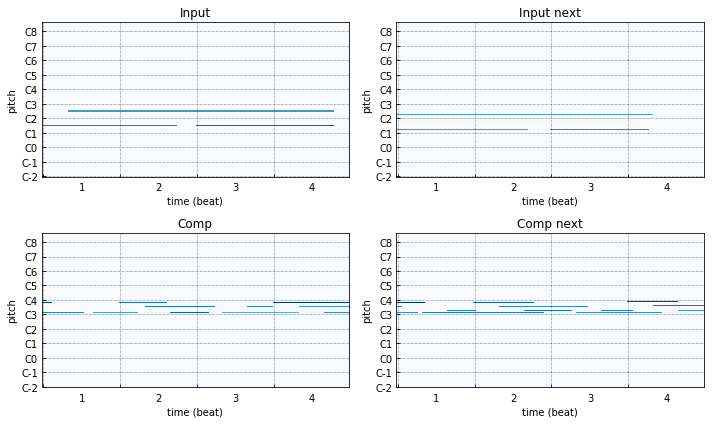

In [31]:

# Plot random input unit along with corresponding next and comp units
unit_index = np.random.randint(units["input"].shape[0])
pianoroll_utils.plot_four_units(units, unit_index)


In [32]:

# Listen to the MIDI files
pianoroll_utils.playPianoroll(units["input"][unit_index])
pianoroll_utils.playPianoroll(units["input_next"][unit_index])
pianoroll_utils.playPianoroll(units["comp"][unit_index])
pianoroll_utils.playPianoroll(units["comp_next"][unit_index])

# Listen to the input with the comp
pianoroll_utils.playPianoroll(units["input"][unit_index] + units["comp"][unit_index])
pianoroll_utils.playPianoroll(units["input_next"][unit_index] + units["comp_next"][unit_index])


0